In [33]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

## ------------------------------------- Data Load  --------------------------------------

In [4]:
#reading csv file

house=pd.read_csv('Bengaluru_House_Data.csv')
house

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [3]:
house.shape

(13320, 9)

In [5]:
house.columns

Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [6]:
house.area_type.value_counts()

Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: area_type, dtype: int64

## ------------------------------- droping features which are not required ---------------------------------

In [5]:
# Assumption - dropping columns that are not required for predicting price of house 
blr=house.drop(['area_type','availability','society','balcony'],axis=1)
blr.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


## ----------------------- data cleaning --------------------------------------

#### handling missing values

In [6]:
blr.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [7]:
blr['bath']=blr['bath'].fillna(blr['bath'].median())

In [8]:
blr.isnull().sum()

location       1
size          16
total_sqft     0
bath           0
price          0
dtype: int64

In [9]:
blr['size']=blr['size'].fillna(method='ffill')
blr['location']=blr['location'].fillna(method='ffill')

In [10]:
blr.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

## --------------------------- feature engineering ---------------------------

#### Add new feature(integer) for bhk (Bedrooms Hall Kitchen)

In [11]:
blr['bhk'] = blr['size'].apply(lambda x: int(x.split(' ')[0]))
blr.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18], dtype=int64)

#### explore total_sqft feature

In [12]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [13]:
blr[~blr['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
56,Devanahalli,4 Bedroom,3010 - 3410,2.0,192.000,4
81,Hennur Road,4 Bedroom,2957 - 3450,2.0,224.500,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
224,Devanahalli,3 BHK,1520 - 1740,2.0,74.820,3
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2


#### Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which I am going to just drop

In [14]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [15]:
blr.total_sqft = blr.total_sqft.apply(convert_sqft_to_num)

In [16]:
blr.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

### adding new feature price per sqft

In [17]:
blr['price_per_sqft'] = blr['price']*100000/blr['total_sqft']
blr.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [18]:
blr.price_per_sqft.describe()

count    1.327400e+04
mean     7.907501e+03
std      1.064296e+05
min      2.678298e+02
25%      4.266865e+03
50%      5.434306e+03
75%      7.311746e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [19]:
blr.to_csv("bhp.csv",index=False)

In [20]:
blr.location = blr.location.apply(lambda x: x.strip())
location_stats = blr['location'].value_counts(ascending=False)
location_stats

Whitefield                        541
Sarjapur  Road                    400
Electronic City                   304
Kanakpura Road                    273
Thanisandra                       237
                                 ... 
Bapuji Layout                       1
1st Stage Radha Krishna Layout      1
BEML Layout 5th stage               1
singapura paradise                  1
Abshot Layout                       1
Name: location, Length: 1294, dtype: int64

In [21]:
location_stats.values.sum()

13320

In [22]:
len(location_stats[location_stats>10])

241

In [23]:
len(location_stats)

1294

## ---------------- --------------- dimensionality reduction --------------------------------

#### Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns

In [24]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

Dairy Circle                      10
Nagappa Reddy Layout              10
Basapura                          10
1st Block Koramangala             10
Sector 1 HSR Layout               10
                                  ..
Bapuji Layout                      1
1st Stage Radha Krishna Layout     1
BEML Layout 5th stage              1
singapura paradise                 1
Abshot Layout                      1
Name: location, Length: 1053, dtype: int64

In [25]:
blr.location = blr.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(blr.location.unique())

242

## --------------------- outlier removal ----------------------------

#### As a data scientist when you have a conversation with your business manager (who has expertise in real estate), he will tell you that normally square ft per bedroom is 300 (i.e. 2 bhk apartment is minimum 600 sqft. If you have for example 400 sqft apartment with 2 bhk than that seems suspicious and can be removed as an outlier. We will remove such outliers by keeping our minimum thresold per bhk to be 300 sqft

In [26]:
blr[blr.total_sqft/blr.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


#### Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely

In [27]:
blr1 = blr[~(blr.total_sqft/blr.bhk<300)]
blr1.shape

(12576, 7)

## outlier removal using std and mean

In [28]:
blr1.price_per_sqft.describe()

count     12530.000000
mean       6303.979357
std        4162.237981
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

In [29]:
# removing outlier in price per sqft column with the help of mean and std

# assuming threshold of 3 std 

# per location we need to find mean and std as diff place have different price range 


#### Here we find that min price per sqft is 267 rs/sqft whereas max is 770000, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation

In [41]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-3*st)) & (subdf.price_per_sqft<=(m+3*st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
blr2 = remove_pps_outliers(blr1)
blr2.shape

(12337, 7)

#### Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like

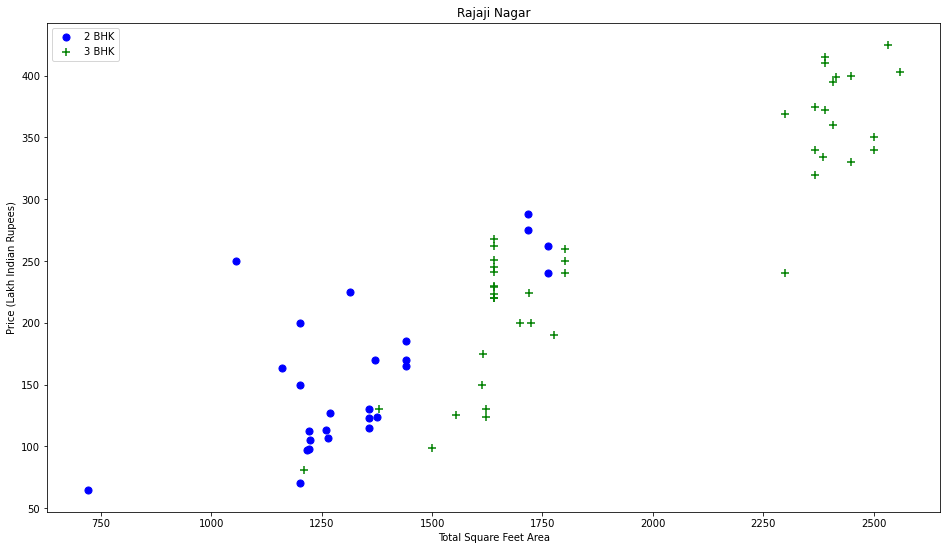

In [42]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    plt.figure(figsize=(16,9))
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(blr2,"Rajaji Nagar")

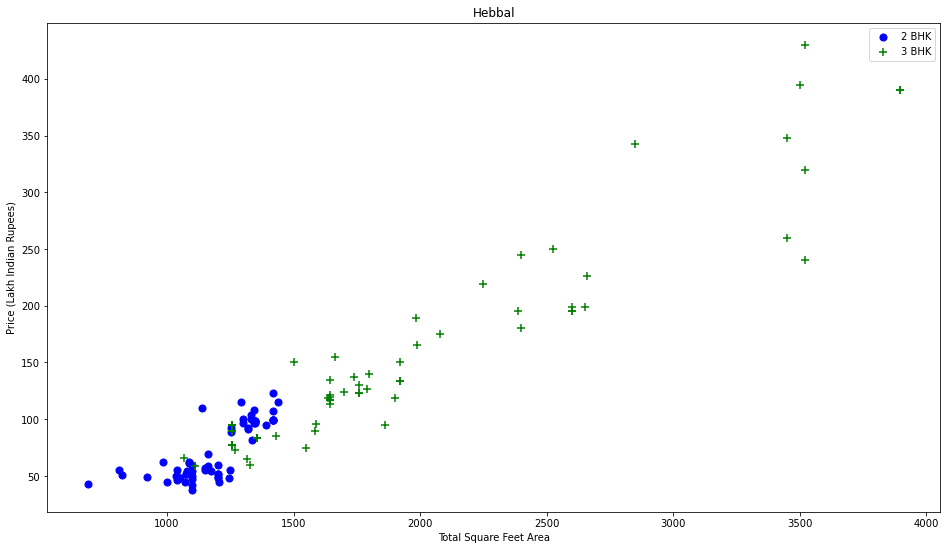

In [43]:
plot_scatter_chart(blr2,"Hebbal")

#### We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk

In [44]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
blr3 = remove_bhk_outliers(blr2)
blr3.shape

(8649, 7)

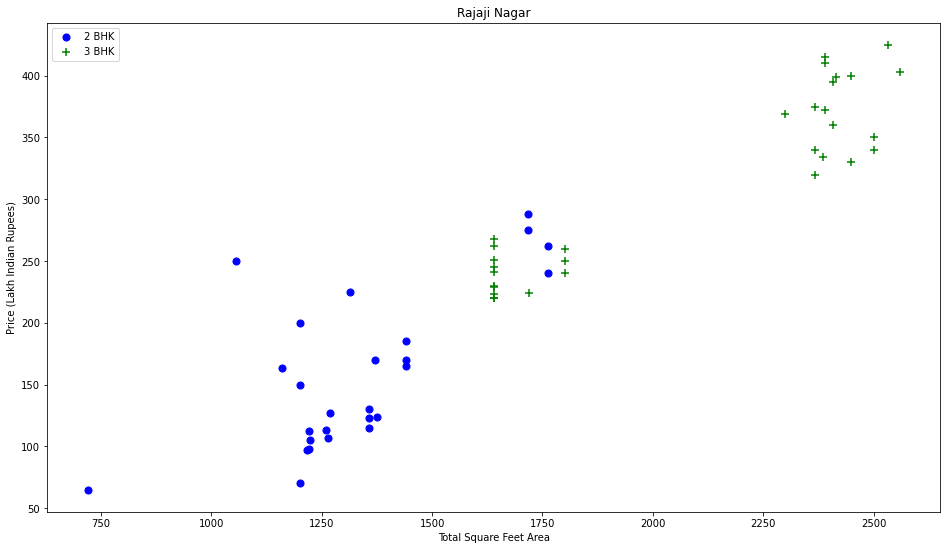

In [45]:
# plotting same scatter plot
plot_scatter_chart(blr3,"Rajaji Nagar")

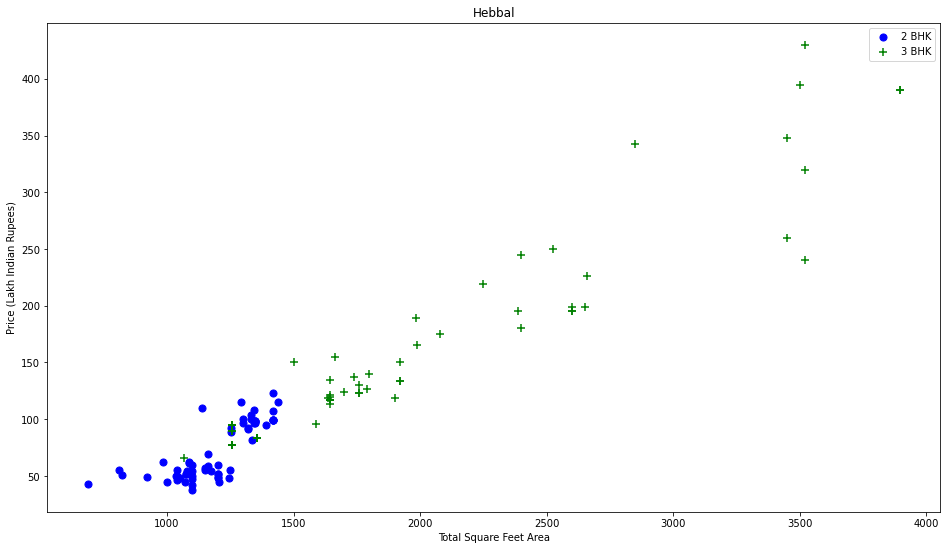

In [46]:
plot_scatter_chart(blr3,"Hebbal")

## outlier for bathroom feature

In [47]:
blr3.bath.unique()

array([ 4.,  3.,  2.,  5.,  7.,  1.,  8.,  6.,  9., 10., 12., 14., 16.,
       13.])

Text(0, 0.5, 'Count')

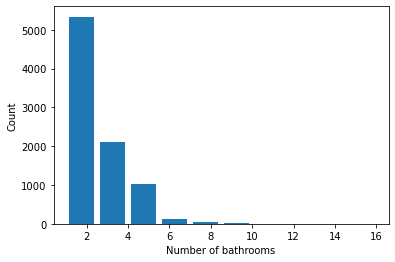

In [48]:
plt.hist(blr3.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [49]:
blr3[blr3.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
6540,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
10039,other,9 Bedroom,3300.0,14.0,500.0,9,15151.515152
10509,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
11322,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
11688,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


#### It is unusual to have 2 more bathrooms than number of bedrooms in a home

#### Again the business manager has a conversation with you (i.e. a data scientist) that if you have 4 bedroom home and even if you have bathroom in all 4 rooms plus one guest bathroom, you will have total bath = total bed + 1 max. Anything above that is an outlier or a data error and can be removed

In [50]:
blr4 = blr3[blr3.bath<blr3.bhk+2]
blr4.shape

(8533, 7)

In [51]:
#dropping unused columns

blr4 = blr4.drop(['size','price_per_sqft'],axis='columns')
blr4.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


## ------------------------------- using one hot encoding ---------------------------------------

In [53]:
dummies = pd.get_dummies(blr4.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
blr5 = pd.concat([blr4,dummies.drop('other',axis=1)],axis=1)
blr5.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1st Block Jayanagar,1630.0,3.0,194.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1st Block Jayanagar,1875.0,2.0,235.0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1st Block Jayanagar,2400.0,4.0,450.0,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1st Block Jayanagar,1000.0,3.0,60.0,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
blr5=blr5.drop(['location'],axis=1)
blr5.head()

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2400.0,4.0,450.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000.0,3.0,60.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## ---------------------------------------- Building model ------------------------------

In [57]:
X = blr5.drop(['price'],axis=1)
y = blr5.price

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [67]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.7393647254892155

### using k fold model to measure accuracy of linear regression model

In [61]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.74017593, 0.69741635, 0.68861028, 0.71974349, 0.48773149])

In [63]:
from sklearn.tree import DecisionTreeRegressor
dt_clf = DecisionTreeRegressor()
dt_clf.fit(X_train,y_train)
dt_clf.score(X_test,y_test)

0.5166114392016841

In [66]:
from sklearn.neighbors import KNeighborsRegressor
knn_clf=KNeighborsRegressor(n_neighbors = 5, metric = 'minkowski', p = 2)
knn_clf.fit(X_train,y_train)
knn_clf.score(X_test,y_test)

0.677438586729091

### testing model for few properties 

In [68]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [69]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


74.68518452683693

In [70]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


81.65822892794766

In [71]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


187.40338491368544

In [72]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Anaconda\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


194.37642931479618